# prepare the connectome 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tqdm import tqdm
import os
import random
import re
import math

In [2]:
import torch 
import torch.nn as nn

In [3]:
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seeds(42)

In [4]:
ad = pd.read_csv('/Users/yijieyin/Downloads/larva/Supplementary-Data-S1/ad_connectivity_matrix.csv', index_col=0)
ad.head(10)

,29,9469519,15458316,4393049,4679139,15592696,17327188,15653288,10158972,12842593,...,15762568,15914721,15996271,15998899,15998913,16362243,17608754,17951153,18679889,18785124
29,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9469519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
15458316,0.0,0.0,0.0,8.0,15.0,0.0,2.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4393049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4679139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
15592696,0.0,0.0,0.0,13.0,0.0,0.0,2.0,0.0,0.0,3.0,...,0,0,0,0,0,0,0,0,0,0
17327188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
15653288,0.0,0.0,0.0,0.0,7.0,0.0,2.0,0.0,25.0,13.0,...,0,0,0,0,0,0,0,0,0,0
10158972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
12842593,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


So the columns and rows are skids, and the values are synapse numbers, not input proportion. So we need the total number of synapses on the dendrites for each skid. 

In [5]:
# sum across rows, for each column 
# ad.sum(axis='rows')
# calculate input proportion. Divide for each column 
ad_inprop = ad.div(ad.sum(axis = 'rows'),axis = 'columns')
ad_inprop.fillna(0, inplace=True)
# turn index into string from int64 
ad_inprop.index = ad_inprop.index.map(str)
ad_inprop.head()

,29,9469519,15458316,4393049,4679139,15592696,17327188,15653288,10158972,12842593,...,15762568,15914721,15996271,15998899,15998913,16362243,17608754,17951153,18679889,18785124
29,0.0,0.002439,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9469519,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15458316,0.0,0.000000,0.0,0.111111,0.08982,0.0,0.068966,0.0,0.007194,0.015385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4393049,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4679139,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## inhibitory neurons

In [ ]:
import pymaid

rm = pymaid.connect_catmaid()

In [ ]:
gaba = pymaid.find_neurons(annotations='GABA')
glu = pymaid.find_neurons(annotations='glutamate')
inhi = list(gaba.skeleton_id) + list(glu.skeleton_id)

inhibitory_selected = [skid for skid in inhi if skid in ad_inprop.index]
ad_inprop.loc[inhibitory_selected] = ad_inprop.loc[inhibitory_selected].apply(lambda x: x * -1)

## get meta info

In [6]:
meta = pd.read_csv('/Users/yijieyin/Downloads/larva/brain-neurons_meta-data.csv')
meta.head()

,leftid,rightid,celltype,annotated_name,left_name,right_name,cluster
0,no pair,8447845,sensory,visual,no pair,Rh6PR-10;right,0
1,no pair,2544902,sensory,visual,no pair,Rh6PR-5;right,0
2,2206279,no pair,sensory,visual,Rh6PR-3;left,no pair,0
3,no pair,2532841,sensory,visual,no pair,Rh6PR-6;right,0
4,no pair,1856512,sensory,visual,no pair,Rh6PR-4;right,0


In [7]:
# how many cells on one side (roughly)? 
meta.shape

(1648, 7)

In [8]:
# and which types are there? 
meta.celltype.value_counts()

pre-DN-VNC    239
sensory       235
KC            199
other         194
PN            103
LHN           101
DN-VNC         91
DN-SEZ         82
PN-somato      76
LN             56
MB-FBN         54
pre-DN-SEZ     51
CN             50
RGN            27
MB-FFN         27
MBON           24
ascending      23
MBIN           16
Name: celltype, dtype: int64

In [9]:
# what about sub-type?
meta.annotated_name.value_counts()

no official annotation          781
KC                              121
KC; partially differentiated     78
gustatory-external               66
gustatory-pharyngeal             56
                               ... 
FFN-13                            1
FFN-11                            1
FB2N-9                            1
FB2N-4                            1
OAN-a1                            1
Name: annotated_name, Length: 301, dtype: int64

In [10]:
# how many neurons on the right without a contralateral homologue? 
sum(meta.leftid == 'no pair')

121

In [11]:
sum(meta.rightid == 'no pair')

107

In [12]:
# which kind of sensory neurons are there? 
meta[meta.celltype.isin(['sensory'])]['annotated_name'].value_counts()

gustatory-external      66
gustatory-pharyngeal    56
enteric                 45
visual                  29
olfactory               21
respiratory             13
thermo-cold              3
thermo-warm              2
Name: annotated_name, dtype: int64

## make a type dictionary

In [13]:
# there are many values in the left_id or right_id column that is 'no pair'. So multiple values are assigned to the 'no pair' key. 
# when this happens, only the last value is retained in the dictionary. 
# but this is okay because we don't care about the 'no pair' ids. 
types = dict(zip(pd.concat([meta.leftid, meta.rightid]),
                 pd.concat([meta.celltype,meta.celltype])))
# have a look at a few 
dict(list(types.items())[0:5])

{'no pair': 'other',
 '2206279': 'sensory',
 '2216445': 'sensory',
 '2215247': 'sensory',
 '10241716': 'sensory'}

In [14]:
types_add = dict(zip(pd.concat([meta.leftid, meta.rightid]),
                 pd.concat([meta.annotated_name,meta.annotated_name])))

In [15]:
# and a neuron name dictionary 
names = dict(zip(pd.concat([meta.leftid, meta.rightid]),
                 pd.concat([meta.left_name,meta.right_name])))

In [16]:
# and a side dictionary 
sides = dict.fromkeys(meta.leftid, 'left')
sides.update(dict.fromkeys(meta.rightid, 'right'))

## total input contributed by senses 
At different steps 

In [17]:
sensories = [skid for skid, tp in types.items() if tp == 'sensory']

In [18]:
# a function that takes in skids as starting points, and calculate the amount of input contributed by those skids, for n steps 
def generate_steps(skids, ad_inprop, step_number): 
    # create the inital almost-identity matrix 
    ini = ad_inprop.copy()
    # turn all values to 0, then assign 1 to the sensory ones on the diagonal 
    for col in ini.columns:
        ini[col].values[:] = 0
        if col in skids:
            ini.loc[col,col] = 1
    
    steps_fast = []
    for i in tqdm(range(step_number)): 
        # e.g. if step_number is 2, then range(step_number) is [0,1] 
        # the if i==0 block gives 'how many neurons receive direct* input from skids, as shown in the connectome' 
        # then the i=1 step gives 'how many neurons receive input from skids, with one neuron in the middle' 
        if i==0: 
            # the first step of signal propagation 
            steps_fast.append(ini@np.linalg.matrix_power(ad_inprop, 1))
            steps_fast[-1].columns = steps_fast[-1].index.copy()
        else: 
            # multiply the last result  with ad_inprop 
            steps_fast.append(steps_fast[-1]@ad_inprop)
    
    return steps_fast

In [19]:
steps = generate_steps(sensories, ad_inprop, 15)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:20<00:00,  1.38s/it]


In [20]:
# sum the first n steps 
def add_steps(steps, n): 
    # n must be 1 or larger 
    m = steps[0].copy()
    # the first step of signal propagation 
    if n==1: 
        return m
    else: 
        for i in range(n-1): 
            m = m + steps[i+1]
        return m

In [21]:
# we should exclude the sensory neurons in the columns, and non-sensory neurons in the rows (since the values are 0 anyway) 
not_sensory = [types[idx]!='sensory' for idx in steps[0].index]
sensory = [types[idx]=='sensory' for idx in steps[0].index]
steps_nosense = []
for m in steps: 
    m.columns = m.index
    steps_nosense.append(m.loc[sensory,not_sensory])

In [22]:
n = 14
stepsn = add_steps(steps_nosense, n)

In [23]:
stepsn

,29,9469519,4393049,4679139,17327188,10158972,12842593,3844799,8700125,9927082,...,14913093,10949382,16952648,13774384,17356467,20316708,13775497,11717025,11717035,12367135
15458316,0.000199,0.000679,0.111116,0.089847,0.068968,0.007294,0.015385,0.017937,0.000028,0.000011,...,0.0,0.0,0.000897,0.000968,0.000907,0.0,0.0,0.0,0.0,0.000316
15592696,0.000366,0.001275,0.180562,0.000171,0.068972,0.000076,0.046154,0.035769,0.000042,0.000017,...,0.0,0.0,0.001554,0.001851,0.001433,0.0,0.0,0.0,0.0,0.000477
15653288,0.000663,0.002137,0.000011,0.041975,0.068973,0.180019,0.200000,0.169898,0.000058,0.000017,...,0.0,0.0,0.002892,0.003762,0.002740,0.0,0.0,0.0,0.0,0.000784
37365,0.000030,0.000102,0.000002,0.000012,0.000001,0.000018,0.000000,0.000010,0.068347,0.126444,...,0.0,0.0,0.000800,0.000975,0.001213,0.0,0.0,0.0,0.0,0.000600
40045,0.005048,0.001964,0.000036,0.000249,0.000014,0.000273,0.000000,0.000142,0.000248,0.000283,...,0.0,0.0,0.007996,0.007003,0.008691,0.0,0.0,0.0,0.0,0.001471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16362243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
17608754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
17951153,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
18679889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


In [24]:
np.mean(stepsn.unstack() == 0)

0.20319790494808476

In [25]:
sum(stepsn.unstack() == 0)

220360

In [26]:
# how many possible connections? 
430*2522

1084460

In [27]:
# what's the sparsity (very weakly connected neurons still count)
220360/1084460

0.20319790494808476

# sensory hierarchical clustering

This section intends to generate a sequence of sensory neurons, that put neurons that do similar things together, later in the interactive plots. 

In [28]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree, leaves_list

In [29]:
# generate a sensory_neuron to non_sensory_cell_type connectivity 
# this is to keep the sensory neurons of different hemispheres together during clustering 
stepsnt = stepsn.T
# add type information to the non-sensory neurons 
stepsnt['type_additional'] = stepsnt.index.map(types_add)

# Split the DataFrame into two parts: one with 'no official annotation' and the other without
stepsnt_no_official_annotation = stepsnt[stepsnt['type_additional'] == 'no official annotation']
stepsnt_other_types = stepsnt[stepsnt['type_additional'] != 'no official annotation']

# Group by the 'type' column and sum the values for the other types
result_other_types = stepsnt_other_types.groupby('type_additional').sum()

# Concatenate the two DataFrames back together
result = pd.concat([stepsnt_no_official_annotation, result_other_types])
result = result.drop(['type_additional'], axis = 1).T
result

,17327188,8700125,8877971,5030808,10263287,12335381,3946166,17698681,17360038,17165429,...,mechano-II/III 2nd_order PN,noci,noci 2nd_order PN,noci 2nd_order PN; mechano-Ch 2nd_order PN,partially differentiated,proprio,proprio 2nd_order PN,respiratory 2nd_order PN,unknown modality,vPN; visual 2nd_order PN
15458316,0.068968,0.000028,0.000016,0.000067,0.0,0.000012,0.001376,0.0,0.000736,0.001165,...,0.016380,0.003978,0.045038,0.003503,0.000503,0.002872,0.015444,0.002677,0.003111,0.000736
15592696,0.068972,0.000042,0.000038,0.000096,0.0,0.000015,0.001919,0.0,0.001317,0.001967,...,0.020960,0.006539,0.082708,0.006342,0.000727,0.005040,0.024192,0.003852,0.005220,0.001637
15653288,0.068973,0.000058,0.000032,0.000140,0.0,0.000113,0.003486,0.0,0.002090,0.002180,...,0.035346,0.011716,0.132235,0.007189,0.001367,0.012552,0.049560,0.006570,0.010378,0.001188
37365,0.000001,0.068347,0.000005,0.000029,0.0,0.000003,0.000670,0.0,0.000680,0.002024,...,0.005746,0.004431,0.041851,0.012876,0.000255,0.002260,0.008394,0.001339,0.002465,0.094339
40045,0.000014,0.000248,0.068165,0.033960,0.0,0.000120,0.006525,0.0,0.002447,0.002665,...,0.065653,0.017208,0.168140,0.011838,0.001106,0.021596,0.137334,0.012950,0.016030,0.006562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16362243,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17608754,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17951153,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18679889,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [32]:
linkage_data = linkage(result, method='ward', metric='euclidean')

In [33]:
# make labels for the plots later 
# label by names 
labs = [names[skid] for skid in stepsn.index]
# map between names and modality for sensory neuron 
name_typeadd_dict = dict([(names[skid], types_add[skid]) for skid in stepsn.index])
sens_typeadd = set(name_typeadd_dict.values())
# mapping between modality and colour 
sens_typeadd_col = dict(zip(sens_typeadd, 
                            sns.color_palette('husl',len(sens_typeadd)).as_hex()))
sens_typeadd_col

{'gustatory-external': '#f77189',
 'thermo-warm': '#ce9032',
 'gustatory-pharyngeal': '#97a431',
 'enteric': '#32b166',
 'thermo-cold': '#36ada4',
 'visual': '#39a7d0',
 'olfactory': '#a48cf4',
 'respiratory': '#f561dd'}

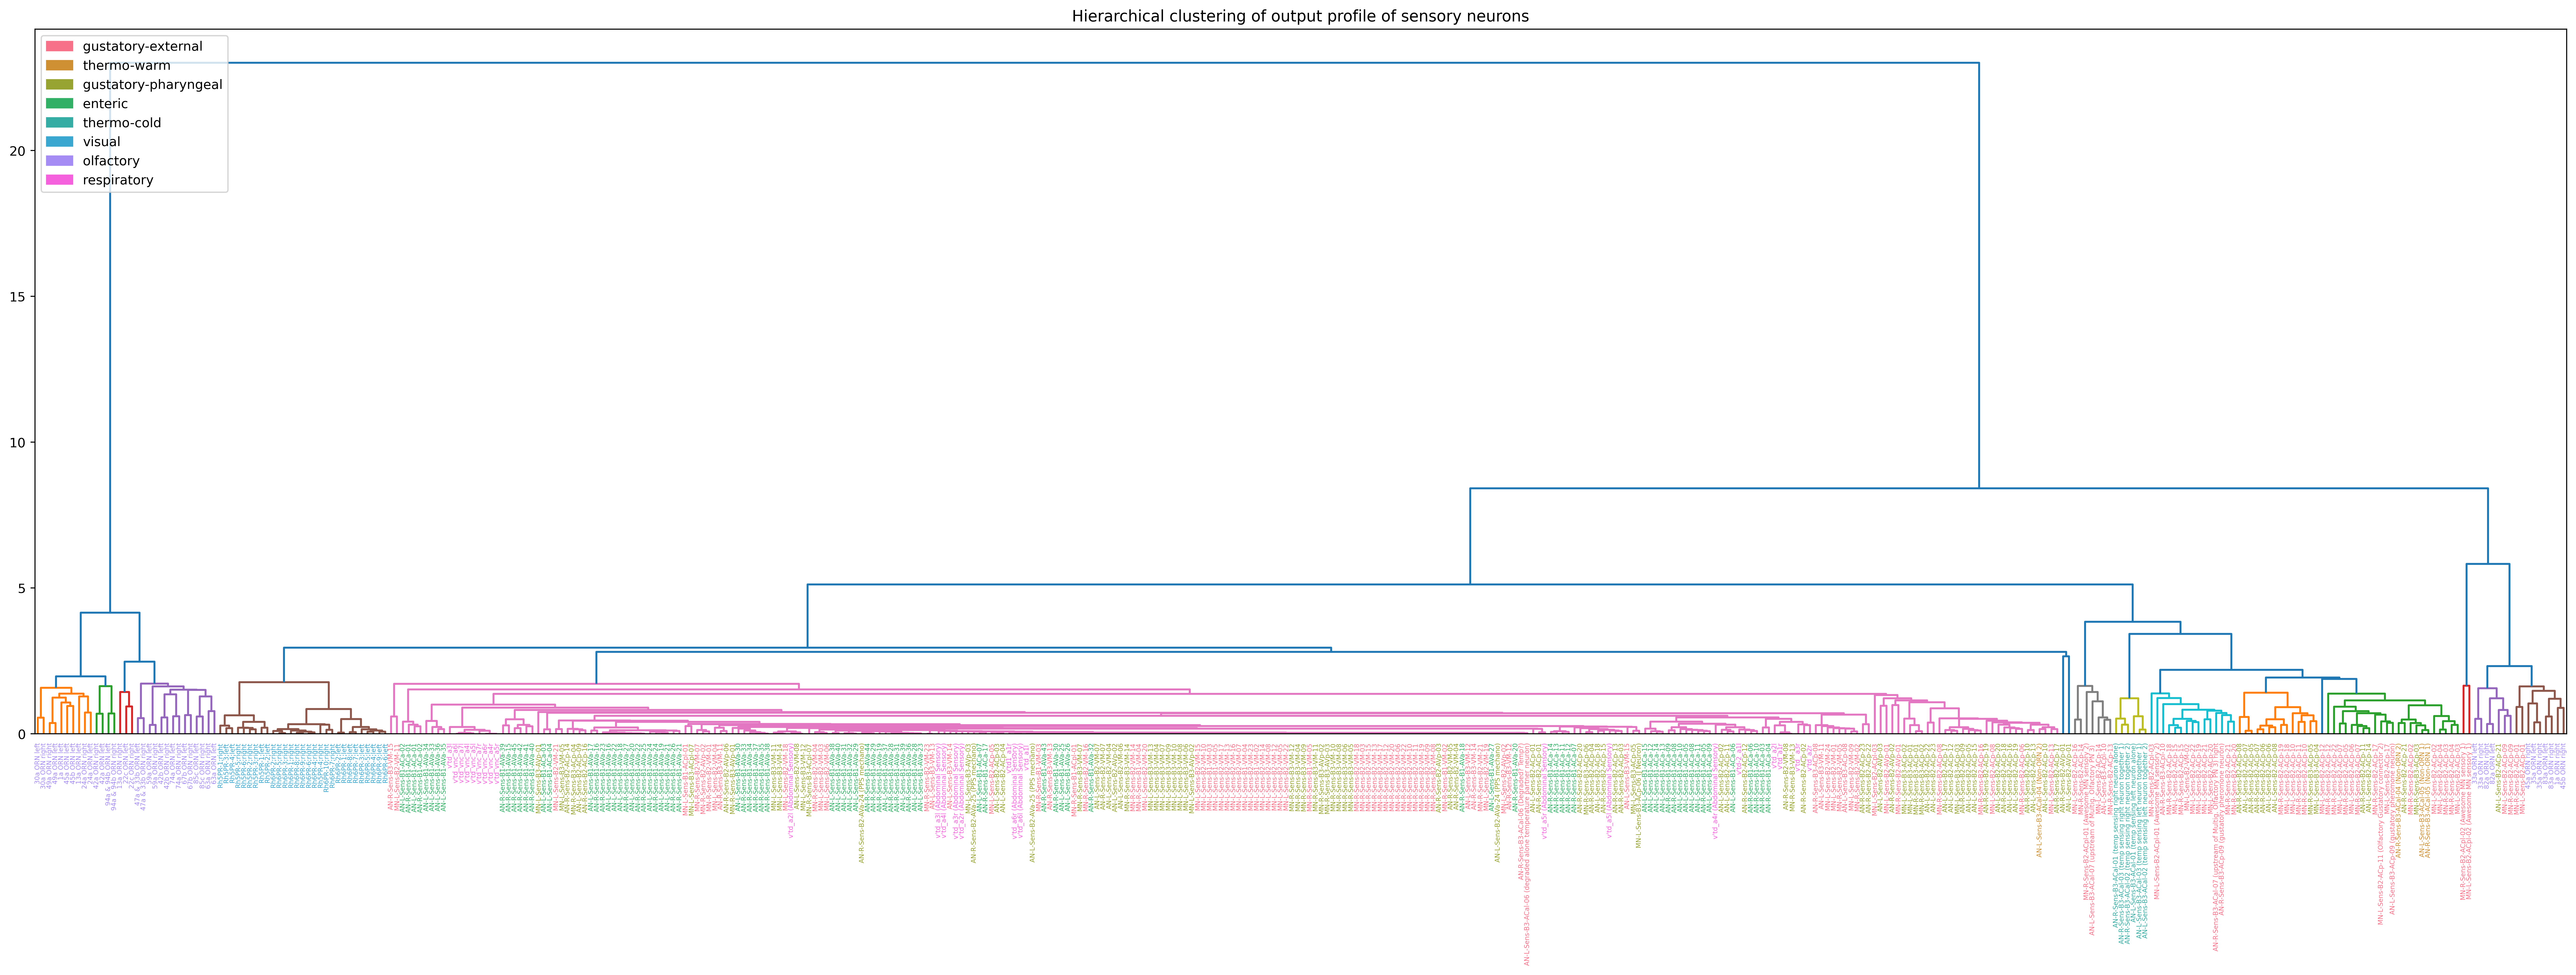

In [36]:
plt.figure(figsize = (35,10), dpi = 400)

dendrogram(linkage_data, labels = labs, color_threshold = 1.8)

# add colours to labels 
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(sens_typeadd_col[name_typeadd_dict[lbl.get_text()]])

# add legend 
# Create a list of patches
patches = [mpatches.Patch(color=color, label=label) for label, color in sens_typeadd_col.items()]
# Create a legend from these patches
plt.legend(handles=patches, loc='upper left') 

plt.title('Hierarchical clustering of output profile of sensory neurons')

plt.show()
# plt.savefig('/Users/yijieyin/Downloads/larva_sensory_hclust.pdf', bbox_inches='tight')

In [ ]:
# Make clusters 
cl = cut_tree(linkage_data, height=1.8)[:, 0]

In [37]:
# function to plot activation
# Preset order of 'skid'
preset_order = stepsn.index[leaves_list(linkage_data)]

def plot_activation(input_df):
    # Takes a dataframe of columns `skid` and `activation` 
    
    # Create template dataframe with preset skid order
    template_df = pd.DataFrame({'skid': preset_order})
    
    # Map sense onto input dataframe
    input_df.columns = ['skid','activation']
    # add type info 
    input_df.loc[:,'sense'] = input_df['skid'].map(types_add)
    
    # Merge input dataframe onto template dataframe to maintain skid order
    df = template_df.merge(input_df, on='skid', how='left')

    g = sns.catplot(
        data=df, kind="bar",
        x="skid", y="activation", row="sense", hue = 'sense',
        height=2, aspect=10, 
        sharex=False, 
        palette = sens_typeadd_col
    )

    # Remove x-tick labels and y-axis labels
    g.set(xticklabels=[], ylabel='', xlabel = '')

    # Set the facet titles, adjust their size and position
    for ax in g.axes.flatten():  
        ax.set_title(ax.get_title(), fontsize='xx-large', y = 0.85)

    # Adjust vertical spacing 
    g.fig.subplots_adjust(hspace=0.1)

    plt.show()

# ANN
## guidance by GPT-4
**Preparing the data**: Make sure you have the fruit fly connectome dataset ready in a format that can be easily processed by PyTorch. Convert it to a tensor if it isn't already in that format.

**Building the neural network**: Since you're not confident about creating a neural network from scratch, let's start with a simple feedforward network. You can use the torch.nn.Module class to define your network architecture. Here's a basic example:

```
import torch
import torch.nn as nn

class SimpleNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
```
Customize the input_size, hidden_size, and output_size according to your needs. This is just an example to get you started. In practice, you might need to adjust the architecture, add more layers, or change the activation functions to better model the fruit fly connectome.

Activation maximization: The goal of activation maximization is to find the input that maximally activates a specific neuron or layer in the network. The general approach is to perform gradient ascent on the input, optimizing it to maximize the activation of the selected neuron(s).
Here's an outline of how to do this with PyTorch:

a. Choose the neuron(s) you want to maximize the activation for.

b. Initialize a random input tensor (with the same dimensions as your network's input) and set requires_grad=True to enable gradient computation:

```input_tensor = torch.randn((1, input_size), requires_grad=True)```
c. Define a loss function that represents the activation of the chosen neuron(s). You can use the output of the network for this purpose. For example, if you want to maximize the activation of neuron i in the output layer:

```
output = model(input_tensor)
loss = -output[0, i]  # Negative sign because we want to maximize activation
```
d. Compute gradients using backpropagation and update the input tensor using gradient ascent:

```
optimizer = torch.optim.SGD([input_tensor], lr=learning_rate)
optimizer.zero_grad()
loss.backward()
optimizer.step()
```
e. Repeat steps (c) and (d) for a certain number of iterations or until the loss converges.

Interpreting results: Once the optimization is complete, analyze the input tensor that maximizes the activation of your chosen neuron(s). This should give you insights into what kind of stimuli activate the selected neuron(s) the most.
Remember to adjust the neural network architecture and parameters based on your specific problem and dataset. Good luck!

## building the neural network

In [ ]:
# # example neural network
# class SimpleNetwork(nn.Module): 
#     def __init__(self, input_side, hidden_size, output_siz): 
#         super(SimpleNetwork, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size) 
#         self.relu = nn.ReLU() 
#         self.fc2 = nn.Linear(hidden_size, output_size) 
    
#     def forward(self, x): 
#         x = self.fc1(x) 
#         x = self.relu(x) 
#         x = self.fc2(x) 
#         return x 

`super()` is a built-in Python function used to call the base class (in this case, **nn.Module**) constructor. This is necessary because the base class constructor sets up some internal mechanisms that make the class work with PyTorch. By calling `super(SimpleNetwork, self).__init__()`, you ensure that the base class constructor is properly executed before adding any custom functionality to your `SimpleNetwork` class.

### two layered

In [38]:
class TwoLayerNetwork(nn.Module): 
    def __init__(self, input_size, output_size, weights_tensor): 
        super(TwoLayerNetwork, self).__init__() 
        # fully connected layer 
        self.fc1 = nn.Linear(input_size, output_size, bias=False) 
        self.fc1.weight = nn.Parameter(weights_tensor) 
#         self.relu = nn.ReLU() 
#         self.sigmoid = nn.Sigmoid()
    
    def forward(self, x): 
        x = self.fc1(x) 
        # make x between 0 and 1 
        x = torch.clamp(x, min=0, max=1)
#         x = self.relu(x) 
#         x = self.sigmoid(x)  # Add the Sigmoid activation function to make outputs between 0 and 1 
        return x

In [39]:
# turn connectome into a tensor 
numpy_array = stepsn.to_numpy()
weights_tensor = torch.from_numpy(numpy_array).float().t()
weights_tensor.shape

torch.Size([2522, 430])

In [40]:
input_size = stepsn.shape[0]
output_size = stepsn.shape[1]
twol_model = TwoLayerNetwork(input_size, output_size, weights_tensor) 
print(f"Input shape is {input_size}, output shape is {output_size}.")

Input shape is 430, output shape is 2522


### multi-layered (unroll through time)

In [56]:
class MultilayeredNetwork(nn.Module): 
    # this network unrolls the connectome through time: 
    # first layer is sensory to non-sensory 
    # later layers are non-sensory to non-sensory 
    # there will likely be a problem with vanishing/exploding gradient the more layers you have 
    def __init__(self, sensory_weights, weights_nonsense, num_layers=2, threshold = 0.01): 
        super(MultilayeredNetwork, self).__init__()
        self.sensory_weights = torch.nn.parameter.Parameter(sensory_weights)
        self.weights = torch.nn.parameter.Parameter(weights_nonsense.T) 
        self.num_layers = num_layers
        self.threshold = threshold
        self.activations = []  # List to save the activations of the middle layers
    
    def forward(self, x):
        self.activations = []  # Clear the list at the start of each forward pass

        # first multiply by weights 
        x = x@self.sensory_weights.T
        # you can write your own activation function 
        # this is a thresholded ReLU 
        x = torch.where(x >= self.threshold, x, 0)
        self.activations.append(x)  # Save the activations after the first layer

        for i in range(self.num_layers-1):
            x = x@self.weights 
            x = torch.where(x >= self.threshold, x, 0)
            # make x between 0 and 1 
            x = torch.tanh(x)
            self.activations.append(x)  # Save the activations after each layer

        return x

In [57]:
is_sensory = np.array([types[idx] == 'sensory' for idx in ad_inprop.index])
# from sensory to non-sensory 
# input is in the COLUMNS - column vectors 
sensory_weights = torch.from_numpy(ad_inprop.loc[is_sensory, ~is_sensory].to_numpy()).float().t()
# from non-sensory to non-sensory
weights_nonsense = torch.from_numpy(ad_inprop.loc[~is_sensory, ~is_sensory].to_numpy()).float().t()
ml_model = MultilayeredNetwork(sensory_weights, weights_nonsense, num_layers=3)

### activation maximisation

In [43]:
# choose which neuron to maximise the activation for 
selected_indices = [idx for idx, key in enumerate(stepsn.columns) if types_add[key] == 'DAN-j1']
selected_indices

[1326, 1359]

In [44]:
def get_input_size(model):
        # only the first iteration is run 
        for param in model.parameters():
            return param.shape[1]
        
def activation_maximisation(model, target_indices, layer_index = None, input_tensor = None, 
                            num_iterations = 3000, learning_rate = 0.01, 
                            regularisation_lambda = 0.1, regularisation_norm_order = 0.5, 
                            use_tqdm = True, print_output = True): 
    """
    For now intended to work with one input_tensor at a time. 
    """

    if input_tensor is None: 
        input_size = get_input_size(model)
        input_tensor = torch.rand((1, input_size), requires_grad = True)
    
    output_before = model(input_tensor)
    if print_output: 
        print("Output before optimization:", torch.mean(output_before[0,target_indices]).item())

    optimizer = torch.optim.Adam([input_tensor], lr=learning_rate)

    losses = []
    act_loss = []
    reg_losses = []
    iteration_range = range(num_iterations)
    if use_tqdm:
        iteration_range = tqdm(iteration_range)
    for _ in iteration_range:
        optimizer.zero_grad()
        # Forward pass
        output = model(input_tensor)
        
        # Check if the model has an 'activations' attribute 
        # This is checking which of the model, two-layered or multi-layered, is being used 
        if hasattr(model, 'activations'): 
            # If so, use the activations of the specified layer to compute the activation loss
            # Negative sign because we want to maximize activation 
            if layer_index is not None:
                activation_loss = -torch.mean(model.activations[layer_index][0,target_indices])
            else: 
                # mean level of activation for all neurons for all times 
                activation_loss = -torch.mean(ml_model.activations[selected_indices,:])
        else:
            # If not, use the final output of the model to compute the activation loss
            activation_loss = -torch.mean(output[0,target_indices])

        # torch.norm(p = 1): sum of the absolute values of the tensor's elements - l1 regularisation 
        # dividing by input_tensor.shape[1] hopefully normalises this term to be similar to activation_loss 
        regularisation_loss = regularisation_lambda * torch.norm(input_tensor, p=regularisation_norm_order) / input_tensor.shape[1]

        # need to make sure that the two terms are on the same scale 
#         loss =  activation_loss + regularisation_loss + 1
        # possible alternative loss function: 
#         loss = regularisation_loss / -activation_loss
        loss = activation_loss + regularisation_loss
#         loss = regularisation_loss*(1+activation_loss)
        act_loss.append(activation_loss.item())
        reg_losses.append(regularisation_loss.item())

        # Backward pass and optimization
        loss.backward()

        optimizer.step()

    # print("Input tensor after optimization:", input_tensor)
    output_after = model(input_tensor)
    # note that this isn't necessarily in the loss function, if you care about the activation of intermediate neurons. 
    if print_output: 
        print("Output after optimization:", torch.mean(output_after[0,target_indices]).item())
    
    return (input_tensor.detach().numpy(), output_after.detach().numpy(), act_loss, reg_losses)

In [73]:
def plot_losses(activation_loss, regularisation_loss, figsize = (10,5)): 
    fig, ax = plt.subplots(1,2, figsize = figsize)
    ax[0].plot(activation_loss) 
    ax[0].set_title('Activation loss')
    ax[1].plot(regularisation_loss)
    ax[1].set_title('Regularisation loss')

In [45]:
# two layered model 
optimised_in, out, act_loss, reg_loss = activation_maximisation(twol_model, selected_indices, layer_index = 2,
                                                                num_iterations = 400, regularisation_norm_order = 0.5, 
                                                               regularisation_lambda = 0.005, learning_rate = 0.05)

Output before optimization: 0.46169936656951904


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 211.29it/s]

Output after optimization: 1.0


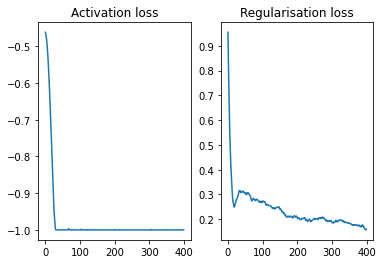

In [48]:
plot_losses(act_loss, reg_loss)

In [68]:
# multi-layered model 
optimised_in, out, act_loss, reg_loss = activation_maximisation(ml_model, selected_indices, layer_index = 2,
                                                                num_iterations = 5000, regularisation_norm_order = 0.5, 
                                                               regularisation_lambda = 0.001, learning_rate = 0.05)

Output before optimization: 0.08217089623212814


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:09<00:00, 20.05it/s]

Output after optimization: 0.6594954133033752


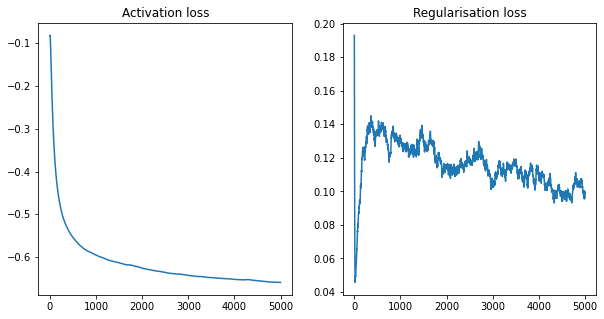

In [74]:
plot_losses(act_loss, reg_loss)
plt.savefig('/Users/yijieyin/Documents/Cardona/first_year_report/multi_layer_losses.pdf')

In [106]:
# names of most activated sensory neurons, activation in descending order 
stepsn.index[np.argsort(optimised_in)[0][0:30]].map(names)

Index(['Rh5PR-4;left', 'MN-R-Sens-B3-VM-12', 'AN-L-Sens-B2-ACp-22', 'v'td_a2l',
       'v'td_a6r (Abdominal Sensory)', 'MN-L-Sens-B3-ACpl-07',
       'MN-L-Sens-B3-VM-05', 'MN-R-Sens-B2-ACp-17', 'Rh6PR-4;left',
       'AN-L-Sens-B3-ACal-07 (upstream of Multig. Olfactory PN 3) ',
       'MN-L-Sens-B2-VM-24', 'AN-L-Sens-B2-ACp-21', 'MN-R-Sens-B2-ACp-20',
       'AN-R-Sens-B2-AVa-25 (PPS mechano)', 'MN-L-Sens-B2-VM-14',
       'AN-R-Sens-B1-AVa-19', 'v'td_vnc_a6r', '1a ORN left',
       'MN-R-Sens-B2-VM-03', 'AN-L-Sens-B1-AVa-31', 'MN-R-Sens-B2-ACp-03',
       'MN-L-Sens-B2-ACp-22', 'AN-R-Sens-B1-AVa-22', 'MN-L-Sens-B2-VM-04',
       '24a ORN left', 'AN-L-Sens-B3-ACpl-10', 'AN-R-Sens-B2-ACp-13',
       'AN-R-Sens-B3-ACal-02 (temp sensing right neuron together 2)',
       'MN-L-Sens-B3-ACp-06 (J Neuron)', 'AN-R-Sens-B2-VM-04'],
      dtype='object')

In [107]:
# names of most activated sensory neurons
stepsn.index[np.argsort(optimised_in)[0][0:30]].map(types_add)

Index(['visual', 'gustatory-pharyngeal', 'gustatory-pharyngeal', 'respiratory',
       'respiratory', 'gustatory-pharyngeal', 'gustatory-pharyngeal',
       'gustatory-external', 'visual', 'gustatory-external',
       'gustatory-external', 'gustatory-pharyngeal', 'gustatory-external',
       'gustatory-pharyngeal', 'gustatory-external', 'enteric', 'respiratory',
       'olfactory', 'gustatory-external', 'enteric', 'gustatory-external',
       'gustatory-external', 'enteric', 'gustatory-external', 'olfactory',
       'gustatory-external', 'gustatory-pharyngeal', 'thermo-cold',
       'gustatory-pharyngeal', 'gustatory-pharyngeal'],
      dtype='object')

### multi-layered with timed input

In [114]:
class MultilayeredNetwork(nn.Module): 
    # this network unrolls the connectome through time: 
    # first layer is sensory to non-sensory 
    # later layers are of the shape all_neurons * non-sensory 
    # each layer takes their own sensory input 
    # there will likely be a problem with vanishing/exploding gradient the more layers you have 
    def __init__(self, sensory_weights, weights_nonsense, num_layers=2, threshold = 0.01): 
        super(MultilayeredNetwork, self).__init__()
        self.sensory_weights = torch.nn.parameter.Parameter(sensory_weights)
        # output * input (both sensory and non-sensory, SENSORY FIRST) 
        self.weights = torch.nn.parameter.Parameter(torch.concat([sensory_weights, weights_nonsense], axis = 1)) 
        self.num_layers = num_layers
        self.threshold = threshold
        self.activations = []  # List to save the activations of the middle layers
    
    def forward(self, inthroughtime):
        # inthroughtime is like an 'image': neurons * timesteps 
        self.activations = []  # Clear the list at the start of each forward pass
        inthroughtime = torch.tanh(inthroughtime)
#         inthroughtime = torch.sigmoid(inthroughtime)
        
        # first multiply by weights 
        x = self.sensory_weights@inthroughtime[:,0]
        # you can write your own activation function 
        # this is a thresholded ReLU 
        x = torch.where(x >= self.threshold, x, 0)
        x = torch.tanh(x)
#         x = torch.sigmoid(x)
        self.activations.append(x)  # Save the activations after the first layer
        
        for i in range(self.num_layers-1):
            x = self.weights @ torch.concat([inthroughtime[:,i+1], x])
            x = torch.where(x >= self.threshold, x, 0)
#             # limit the range between 0 and 1 
            x = torch.tanh(x)
#             x = torch.sigmoid(x)
            self.activations.append(x)  # Save the activations after each layer
        
        self.activations = torch.stack(self.activations, dim=1)
        return self.activations

In [116]:
is_sensory = np.array([types[idx] == 'sensory' for idx in ad_inprop.index])
# from sensory to non-sensory 
# input is in the COLUMNS - column vectors 
sensory_weights = torch.from_numpy(ad_inprop.loc[is_sensory, ~is_sensory].to_numpy()).float().t()
# from non-sensory to non-sensory
weights_nonsense = torch.from_numpy(ad_inprop.loc[~is_sensory, ~is_sensory].to_numpy()).float().t()

ml_model = MultilayeredNetwork(sensory_weights, weights_nonsense, num_layers=15)

In [117]:
# test 
input_tensor = torch.rand((sensory_weights.shape[1], ml_model.num_layers))
out = ml_model(input_tensor)

In [118]:
# choose which neuron to maximise the activation for 
selected_indices = [idx for idx, key in enumerate(stepsn.columns) if types_add[key] == 'DAN-j1']
selected_indices

[1326, 1359]

In [119]:
def get_input_size(model):
        # only the first iteration is run 
        for param in model.parameters():
            return param.shape[1]
        
def activation_maximisation(model, target_indices, input_tensor = None, 
                            num_iterations = 3000, learning_rate = 0.01, 
                            regularisation_lambda = 0.1, 
                            regularisation_norm_order = 0.5, 
                            use_tqdm = True, print_output = True): 
    """
    For now intended to work with one input_tensor at a time. 
    """

    if input_tensor is None: 
        input_size = get_input_size(model)
        input_tensor = torch.rand((input_size, model.num_layers), requires_grad = True)
    
    output_before = model(input_tensor)
    if print_output: 
        print("Output before optimization:", torch.mean(output_before[selected_indices,:]).item())

    optimizer = torch.optim.Adam([input_tensor], lr=learning_rate)

    losses = []
    act_loss = []
    reg_losses = []
    iteration_range = range(num_iterations)
    if use_tqdm:
        iteration_range = tqdm(iteration_range)
    for _ in iteration_range:
        optimizer.zero_grad()
        # Forward pass
        output = model(input_tensor)
        
        # Check if the model has an 'activations' attribute
        if hasattr(model, 'activations'): 
            # If so, use the activations of the specified layer to compute the activation loss
            # Negative sign because we want to maximize activation 
            # max level of activation for all neurons for all times 
            activation_loss = -torch.mean(model.activations[selected_indices,:])

        # torch.norm(p = 1): sum of the absolute values of the tensor's elements - l1 regularisation 
        regularisation_loss = regularisation_lambda * (torch.norm(input_tensor, p = 1) + torch.norm(input_tensor, p = 2))
        
        # or specify regularisation order 
        # dividing by input_tensor.shape[1] hopefully normalises this term to be similar to activation_loss 
#         regularisation_loss = regularisation_lambda * torch.norm(input_tensor, p=regularisation_norm_order) / input_tensor.shape[0]

        # need to make sure that the two terms are on the same scale 
#         loss =  activation_loss + regularisation_loss + 1
        # possible alternative loss function: 
#         loss = regularisation_loss / -activation_loss
        loss = activation_loss + regularisation_loss
#         loss = regularisation_loss*(1+activation_loss)
        act_loss.append(activation_loss.item())
        reg_losses.append(regularisation_loss.item())

        # Backward pass and optimization
        loss.backward()

        optimizer.step()

    # print("Input tensor after optimization:", input_tensor)
    output_after = model(input_tensor)
    # note that this isn't necessarily in the loss function, if you care about the activation of intermediate neurons. 
    if print_output: 
        print("Output after optimization:", torch.mean(output_after[selected_indices,:]).item())
    
    return (input_tensor.detach().numpy(), output_after.detach().numpy(), act_loss, reg_losses)

In [120]:
optimised_in, out, act_loss, reg_loss = activation_maximisation(ml_model, selected_indices, 
                                                                input_tensor = torch.rand((get_input_size(ml_model), ml_model.num_layers), requires_grad = True),
                                                                num_iterations = 200, 
                                                               regularisation_lambda = 0.0001, learning_rate = 0.05)

Output before optimization: 0.27970588207244873


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:10<00:00,  2.85it/s]

Output after optimization: 0.35567283630371094


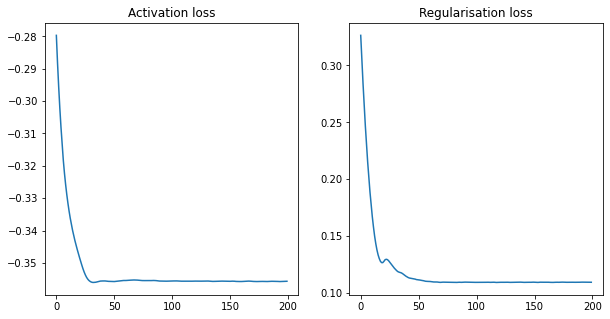

In [121]:
plot_losses(act_loss, reg_loss)

In [78]:
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, ColumnDataSource, TapTool
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

In [122]:
act_time = {'values':optimised_in.tolist(), 
            'axis': [list(range(1,optimised_in.shape[1]+1))]*optimised_in.shape[0],
           'skid': ad_inprop.index[is_sensory]}
act_time['name'] = act_time['skid'].map(names)
act_time['type'] = act_time['skid'].map(types)
act_time['type_add'] = act_time['skid'].map(types_add)

In [123]:
figure_opts = dict(width=1000, height=800)
hover_opts = dict(
    tooltips=[('type_add', '@type_add'), ('Name', '@name'), ('skid', '@skid')],
    show_arrow=False,
    line_policy='next',
)
line_opts = dict(
    line_width=2, line_alpha=0.7,hover_line_alpha=1.0,
    source=act_time,
)

act_plot = figure(tools=[HoverTool(**hover_opts), TapTool()], **figure_opts)
act_plot.multi_line(xs='axis', ys='values', **line_opts)
act_plot.xaxis.axis_label = "Timestep"
act_plot.yaxis.axis_label = "Activation"

show(act_plot)

In [124]:
act_time = {'values':out.tolist(), 
            'axis': [list(range(1,out.shape[1]+1))]*out.shape[0],
           'skid': ad_inprop.index[~is_sensory]}
act_time['name'] = act_time['skid'].map(names)
act_time['type'] = act_time['skid'].map(types)
act_time['type_add'] = act_time['skid'].map(types_add)

figure_opts = dict(width=1000, height=800)
hover_opts = dict(
    tooltips=[('type_add', '@type_add'), ('Name', '@name'), ('skid', '@skid')],
    show_arrow=False,
    line_policy='next',
)
line_opts = dict(
    line_width=2, line_alpha=0.4,hover_line_alpha=1.0,
    source=act_time,
)

act_plot = figure(tools=[HoverTool(**hover_opts), TapTool()], **figure_opts)
act_plot.multi_line(xs='axis', ys='values', **line_opts)
act_plot.xaxis.axis_label = "Timestep"
act_plot.yaxis.axis_label = "Activation"

show(act_plot)

Can't do this in the optimisation loop: 
`input_tensor.data = torch.sigmoid(input_tensor.data)  # Apply the Sigmoid function after each update to make sure it's between 0 and 1`

GPT4: When you apply the Sigmoid function to the input tensor within the loop, you create a new tensor that's not a leaf tensor. Leaf tensors are the ones that you can optimize directly.

## activation maximisation

### all neurons

negative input: 
maybe not long enough? 
maybe loss function? 
remove regularisation and see if you still get negative numbers 

In [ ]:
allins = dict()
allouts = dict()
act_losses = dict()
reg_losses = dict()

for idx, key in enumerate(tqdm(stepsn.columns)): 
    selected_indices = idx
    optimised_in, out, act_loss, reg_loss = activation_maximisation(twol_model, selected_indices, layer_index = 2,
                                                                num_iterations = 800, regularisation_norm_order = 0.5, 
                                                               regularisation_lambda = 0.1, learning_rate = 0.05, 
                                                                   use_tqdm = False, print_output = False)
    allins[key] = optimised_in[0]
    allouts[key] = out[0]
    act_losses[key] = act_loss
    reg_losses[key] = reg_loss

In [ ]:
all_ins = pd.DataFrame(allins)
all_ins

In [ ]:
all_ins.index = stepsn.index
all_ins.fillna(0, inplace=True)
all_ins

In [ ]:
all_ins.to_csv('/Users/yijieyin/Downloads/larva/two_layer_activation_maximisation.csv')

In [ ]:
all_ins.unstack().hist(bins = 50)

In [ ]:
import umap

# !pip install bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, IndexFilter, Spinner, TextInput, CustomJS, Select, LassoSelectTool, Div, Range1d
from bokeh.palettes import Spectral10
from bokeh.io import output_file, show, save
from bokeh.layouts import layout, column, row
from bokeh import events

output_notebook()

In [ ]:
reducer = umap.UMAP()

# dimensions to reduce are in the columns 
in_from_senses_data = all_ins.T.values
embedding = reducer.fit_transform(in_from_senses_data)
embedding.shape

In [ ]:
typecolourdict = pd.read_csv('/Users/yijieyin/Downloads/larva/type_colour_dict.csv')
typecolourdict = dict(zip(typecolourdict.type_name, typecolourdict.colour))

In [ ]:
# prepare the data
all_sensory_bk = pd.concat([all_ins.T,
           pd.DataFrame(embedding, columns=('x', 'y'), index = all_ins.columns)], axis = 1)
all_sensory_bk = all_sensory_bk.round(3)
# add meta info 
all_sensory_bk['neuron_name'] = all_sensory_bk.index.map(names)
all_sensory_bk['type_name'] = all_sensory_bk.index.map(types) 
all_sensory_bk['colour'] = all_sensory_bk.type_name.map(typecolourdict)
all_sensory_bk['type_add'] = all_sensory_bk.index.map(types_add)
all_sensory_bk['side'] = all_sensory_bk.index.map(sides)
all_sensory_bk['skid'] = all_sensory_bk.index
all_sensory_bk

In [ ]:
allin_wmodal = all_ins.copy()
allin_wmodal['modality'] = [types_add[skid] for skid in allin_wmodal.index]
allin_wmodal['name'] = allin_wmodal.index.map(names)
# remove things inside brackets to make x axis tick labels smaller 
# allin_wmodal['name'] = [re.sub('\(.*\)', '', x) for x in allin_wmodal.name]

# Create a dictionary of empty ColumnDataSources, one for each modality
# this specified the sequence of modalities to be plotted 
modalities = ['thermo-cold','thermo-warm','respiratory','visual','olfactory','enteric','gustatory-pharyngeal','gustatory-external']
sources = {modality: ColumnDataSource(data=dict(index=allin_wmodal.index[allin_wmodal.modality.isin([modality])], 
                                                top=[0]*len(allin_wmodal.index[allin_wmodal.modality.isin([modality])]))) for modality in modalities}

In [ ]:
# Create a bar plot for each modality
bar_plots = []
for modality in modalities:
    this_mod = allin_wmodal[allin_wmodal.modality.isin([modality])]
    if modality in ['thermo-cold','thermo-warm']: 
        plot = figure(x_range = list(this_mod.index), title=modality, tools='box_select,reset, wheel_zoom', 
                     width = 200, height = 200)
    elif modality in ['visual','respiratory']: 
        plot = figure(x_range = list(this_mod.index), title=modality, tools='box_select,reset, wheel_zoom', 
                     width = 400, height = 200)
    else: 
        plot = figure(x_range = list(this_mod.index), title=modality, tools='box_select,reset, wheel_zoom', 
                     width = 1300, height = 150)
    plot.vbar(x='index', top='top', source=sources[modality], width=0.5)
    # rotate 45 degrees
    plot.xaxis.major_label_orientation = math.pi/4
    plot.xaxis.axis_label_text_font_size = "2pt"
#     plot.y_range = Range1d(0, 0.3)
    bar_plots.append(plot)

# scatter plot 
datasource = ColumnDataSource(all_sensory_bk)
s2 = ColumnDataSource(all_sensory_bk)

plot = figure(
    title='UMAP projection of individual inputs',
    width=500,
    height = 400,
#     plot_height=600,
    tools=('pan, wheel_zoom, reset, tap, lasso_select')
)

renderer = plot.circle(
    'x',
    'y',
    source=datasource,
    color='colour',
    legend_field = 'type_name',
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4, 
    selection_alpha=1,
    nonselection_alpha=0.05
)
# add a transparent one for selective hovering 
renderer2 = plot.circle(
    'x',
    'y',
    source=s2,
    alpha=0  # set alpha to 0 to make this renderer invisible
)

div = Div(text="Selected neuron name: ", width = 400)
type_select = Select(title="Select Type:", 
                     options=['all'] + list(all_sensory_bk['type_name'].unique()), 
                     value="")

# Define a JavaScript callback function for the widget
type_select_callback = CustomJS(args=dict(source1=datasource, source2=s2, select=type_select, div = div), code="""
    const selected_type = select.value;
    const indices = [];
    const names = []; 
    const data1 = source1.data;
    const data2 = source2.data;
    const typeName = data1.type_name;
    const allNames = data1.neuron_name; 
    for (let i = 0; i < typeName.length; i++) {
        if (typeName[i] === selected_type || selected_type === "all") {
            indices.push(i);
            if (selected_type !== 'all'){
                names.push(allNames[i]); 
            }
        }
    }
    source1.selected.indices = indices;
    source1.change.emit();
    div.text = 'Selected neuron name: ' + names; 
    
    // Update the data of the second data source to match the selected data
    for (let key in data2) {
        data2[key] = data1[key].filter((_, i) => indices.includes(i));
    }
    source2.change.emit();
    
    """)
type_select.js_on_change('value', type_select_callback)

lasso_callback = CustomJS(args=dict(source=datasource, div=div), code="""
    const indices = source.selected.indices;
    const original_indices = indices.map(i => source.data.neuron_name[i]);
    const original_indices_string = original_indices.join(", ");
    // Update the text of the Div
    div.text = "Selected Indices: " + original_indices_string;
""")

plot.js_on_event('selectiongeometry', lasso_callback)


# Define a JavaScript callback to update 'allin_source' when a circle is selected
allin_wmodal_source = ColumnDataSource(allin_wmodal)
callback = CustomJS(args=dict(source=datasource, 
                              sources = sources, 
                              allin_wmodal = allin_wmodal_source, 
                             div = div), 
                    code="""
    var selected_indices = source.selected.indices;
    if (selected_indices.length == 0) {
        return;
    }    
    var selected_skid = source.data['skid'][selected_indices[0]];
    var selected_name = source.data['neuron_name'][selected_indices[0]];
    div.text = "Selected neuron skid: " + selected_skid + '; Neuron name: ' + selected_name;

    // update bar plots 
    for (var modality in sources) {
    var source_to_update = sources[modality];

    var new_data = [];
    for (var i = 0; i < allin_wmodal.data['modality'].length; i++) {
        if (allin_wmodal.data['modality'][i] === modality) {
            new_data.push(allin_wmodal.data[selected_skid][i]);
        }
    }
    console.log(new_data); 
    source_to_update.data['top'] = new_data;
    source_to_update.change.emit();   
    }
""")
plot.js_on_event(events.Tap, callback)


# add text on hover 
plot.add_tools(HoverTool(renderers=[renderer2], tooltips="""
<div>
    <div><span style='font-size: 15px'>@type_add; @neuron_name; @side </span></div>
</div>
"""))

plot.legend.location = "top_right"
plot.legend.label_text_font_size = '8pt'

# Combine all plots together
layout = column(row(column(*bar_plots[0:2]), plot, column(*bar_plots[2:4]), column(type_select, div)), *bar_plots[4:])
# layout = column(row(plot, *bar_plots[4:]), *bar_plots[0:4])

# Show the result
show(layout)

lateralised PED and medial lobe (cvijk, MBIN-l - long term memory? SERT wrap around one of the lobes necessary & sufficient for long term memory)
vertical lobe not very lateralised (defg) 
CA not lateralised: OANs are bilateral 

### hyperparameter exploration

In [ ]:
# Initialize lists to store results
activation_losses = []
regularisation_losses = []
regularisation_norm_orders = []
regularisation_lambdas = []
optimised_inputs = []

# Define line styles for different regularisation_lambda values
line_styles = ['-', '--', '-.', ':']

# Define colors for different regularisation_norm_order values
colors = ['red', 'green', 'blue']

# Define the hyperparameters
regularisation_norm_order_values = [0.5, 1, 2]
regularisation_lambda_values = [0.01, 0.1, 1, 2]

# Loop over hyperparameters
for regularisation_norm_order in regularisation_norm_order_values: 
    for regularisation_lambda in regularisation_lambda_values: 
        # Run the activation maximisation function
        op_input, _, act_loss, reg_loss = activation_maximisation(
            twol_model, 
            selected_indices, 
            layer_index = 1,
            num_iterations = 500, 
            regularisation_norm_order = regularisation_norm_order, 
            regularisation_lambda = regularisation_lambda, 
            learning_rate = 0.1
        )
        
        # Store the losses and the hyperparameters
        activation_losses.append(act_loss)
        regularisation_losses.append(reg_loss)
        regularisation_norm_orders.append(regularisation_norm_order)
        regularisation_lambdas.append(regularisation_lambda)
        optimised_inputs.append(op_input)

# Plot the results
fig, ax = plt.subplots(len(regularisation_norm_order_values), 2, figsize=(15, 5*len(regularisation_norm_order_values)))

# Loop over regularisation_norm_order_values
for i, regularisation_norm_order in enumerate(regularisation_norm_order_values):
    # Activation loss as a function of regularisation_norm_order and regularisation_lambda
    for j, losses in enumerate(activation_losses):
        if regularisation_norm_orders[j] == regularisation_norm_order:
            ax[i, 0].plot(losses, label=f'Lambda: {regularisation_lambdas[j]}', 
                          linestyle=line_styles[regularisation_lambda_values.index(regularisation_lambdas[j])])
    ax[i, 0].set_title(f'Activation loss vs. Iteration (Order: {regularisation_norm_order})')
    ax[i, 0].set_xlabel('Iteration')
    ax[i, 0].set_ylabel('Activation loss')
    ax[i, 0].legend()

    # Regularisation loss as a function of regularisation_norm_order and regularisation_lambda
    for j, losses in enumerate(regularisation_losses):
        if regularisation_norm_orders[j] == regularisation_norm_order:
            ax[i, 1].plot(losses, label=f'Lambda: {regularisation_lambdas[j]}', 
                          linestyle=line_styles[regularisation_lambda_values.index(regularisation_lambdas[j])])
    ax[i, 1].set_title(f'Regularisation loss vs. Iteration (Order: {regularisation_norm_order})')
    ax[i, 1].set_xlabel('Iteration')
    ax[i, 1].set_ylabel('Regularisation loss')
    ax[i, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
act = pd.DataFrame({'skid': stepsn.index, 
                    'activation': optimised_inputs[0][0].detach().numpy()})
plot_activation(act)

In [ ]:
# non-sensory neuron, outputs 
nonsenses = out.detach().tolist()[0]
plt.hist(nonsenses)

In [ ]:
# input sensory neurons 
senses = optimised_in.detach().tolist()[0]
plt.hist(senses)

In [ ]:
# activation of skids after gradient descent 
skid_activation = dict(zip(stepsn.index, senses))
skid_activation.update(dict(zip(stepsn.columns, nonsenses)))

In [ ]:
# whose activation was maximised? 
# by getting act > 1, removing the output, as the output is between 0.5 and 1 
[(types_add[skid], names[skid], skid, act) for skid, act in skid_activation.items() if act > 1]

In [ ]:
# which output is co-activated by the activation of the above sensory neurons? 
[(names[skid], skid, skid_activation[skid]) for skid in stepsn.columns if skid_activation[skid]>0.9]

# saliency

In [ ]:
input_tensor = torch.rand((50, input_size), requires_grad = True)
input_tensor.shape

In [ ]:
def vanilla_gradient(model, samples): 
    # Check if samples requires gradient, if not, set it
    if not samples.requires_grad:
        samples.requires_grad_(True)

    gradients = []
    for i in range(samples.size(0)):  # Loop over each sample
        # sample tensor is created as a result of indexing operation on samples tensor (which itself should 
        # be a leaf tensor), hence it's a non-leaf tensor. So pytorch doesn't automatically remember the gradient 
        # that's why you need to retain grad 
        sample = samples[i:i+1]  # Get the current sample
        # this is of shape (1,input_size). The first one is taken as the batch dimension
        sample.retain_grad()  # Tell PyTorch to store the gradient for this tensor
        
        model.zero_grad()  # Ensure the model has zero gradients
        
        out = model(sample)  # Forward pass
        # though it's called 'loss', it's average neuron activation 
        # if the gradients are positive, it means: when input neuron increases in activation, output also does 
        loss = torch.mean(out[:,selected_indices])  # Compute the loss
        loss.backward()  # Compute gradients

        gradients.append(sample.grad.squeeze(0).clone())  # Store gradients
        # squeeze(0) removes the dimension (in this case the batch one) if the first dimension is 1 
    
    return torch.stack(gradients)  # Stack the list of tensors into one tensor

A similar function in tensorflow: 
```
def vanilla_gradient(model, samples):
    """
    Outputs a saliency map, using the Vanilla Gradient algorithm, indicating
    which input pixels are important for the class predicted by `model` for
    inputs in `samples`
    Args:
        model: a valid TensorFlow Model whose outputs we want to explain
        samples: a Tensor of testing samples with shape (B, H, W, C) which we
                 want to explain
    Returns:
        a 3D tensor with shape (B, H, W) with as many grayscale saliency maps as
        inputs in `samples`
    """
    images = tf.Variable(samples, dtype=float)
    with tf.GradientTape() as tape:
      # pred is two dimensional: one for the particular sample, the other for the probability for that class 
        pred = tf.nn.softmax(model(images, training=False), axis=-1)
        # target_classes = np.argmax(pred.numpy(), axis=-1)
        # loss = []
        # for i, idx in enumerate(target_classes):
        #     loss.append(pred[i:i+1, idx])
        # loss = tf.concat(loss, axis=0)
        # the same as: 
        loss = tf.reduce_max(pred, axis=-1)
        # the above line turns pred into one-dimensional: one class name for each sample 
    grads = tape.gradient(loss, images)
    saliency = saliency_to_grayscale(np.abs(grads))

    return saliency
```
Apparently while tensorflow can compute gradients separately for each input, pytorch cannot. This is because tape.gradient() automatically zeros out gradients after each call, but loss.backward() does not. So we need to use a for loop in pytorch's case. 

In [ ]:
grads = vanilla_gradient(model, input_tensor)
grads.shape

In [ ]:
grads

In [ ]:
stepsn.iloc[:,selected_indices].mean(axis = 1)

:/ 

In [ ]:
tensor = grads.flatten()  # Make it one-dimensional
plt.hist(tensor.detach().numpy(), bins='auto')  # 'auto' automatically determines the number of bins
plt.title("Histogram of tensor values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

## smoothgrad

In [ ]:
def smoothgrad_saliency(model, samples, n_trials = 10, noise_level = 0.1): 
    gradients = []
    for i in range(samples.size(0)): 
        sample = samples[i] 
        # add noise 
        noise = torch.normal(0, noise_level, size = (n_trials,)+sample.shape)
        noisy_samples = sample + noise
        # the shape here would be n_trials, input_size 
        gradients.append(torch.mean(vanilla_gradient(model, noisy_samples), axis = 0))
    return torch.stack(gradients)

In [ ]:
def smoothgrad_saliency(model, samples, n_trials = 10, noise_level = 0.1): 
    gradients = []
    for i in range(samples.size(0)): 
        sample = samples[i] 
        # add noise 
        noise = torch.normal(0, noise_level, size = (n_trials,)+sample.shape)
        noisy_samples = sample + noise
        print(f'Noisy Samples for input {i}: {noisy_samples[:,1:3]}')  # Debug line

        grad = torch.mean(vanilla_gradient(model, noisy_samples), axis = 0)
        print(f'Gradient for input {i}: {grad[1:3]}')  # Debug line
        gradients.append(grad)
    return torch.stack(gradients)


In [ ]:
out = smoothgrad_saliency(model, input_tensor)
out 

In [ ]:
out.shape